<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/A2C_OTHELLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q -q -q -U 'ray[default]'
#import ray

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import copy

import matplotlib.patches as pat
import seaborn as sns

from tqdm.notebook import tqdm

# Agent

In [2]:
class Agent_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.1)
        self.drop3 = nn.Dropout(p=0.1)
        self.drop4 = nn.Dropout(p=0.1)

        self.flatten = nn.Flatten()

        self.pi_net = nn.Linear(64*8*8, 64)
        self.pi_act = nn.Softmax(dim=1)

        self.V_net = nn.Linear(64*8*8, 1)
        self.V_act = nn.Tanh()

    def forward(self, x):
        x  = self.relu(self.bn1(self.conv1(x)))
        x  = self.drop1(x)

        x  = self.relu(self.bn2(self.conv2(x)))
        x  = self.drop2(x)

        x  = self.relu(self.bn3(self.conv3(x)))
        x  = self.drop3(x)

        x  = self.relu(self.bn4(self.conv4(x)))
        x  = self.flatten(x)
        x  = self.drop4(x)

        pi = self.pi_act( self.pi_net(x) )
        V  = self.V_act(  self.V_net(x) )
        return pi, V
    
    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    def set_weights(self, weights):
        self.load_state_dict(weights)

    def get_gradients(self):
        grads = []
        for p in self.parameters():
            grad = None if p.grad is None else p.grad.data.cpu().numpy()
            grads.append(grad)
        return grads

    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

In [3]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'pi_prob', 'v_value'))

class Agent_Memory():
    def __init__(self):
        #self.capacity = ADVANTAGE #Advantageを計算するために、Xstep分の履歴を保存する
        self.memory = []
        self.index = 0
    
    def put_memory(self, state, action, reward, pi_prob, v_value):
        '''transition = (self, state, action, reward, pi_prob, v_value)をメモリに保存する'''
        #if len(self.memory) < self.capacity:
        self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, pi_prob, v_value)
        self.index = (self.index + 1) #% self.capacity  # 保存するindexを1つずらす

    def get_Advantage(self, Last_V):
        transitions = self.memory
        #State, Action, Reward, State_Nextの各要素ごとにまとめ直しTensorに変換する
        BATCH = Transition(*zip(*transitions)) 
        State_BATCH   = torch.tensor( np.stack( BATCH.state ) ,dtype=torch.float)
        Action_BATCH  = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH  = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        Pi_prob_BATCH = torch.stack( BATCH.pi_prob )
        V_value_BATCH = torch.stack( BATCH.v_value )

        # Nstep分の割引報酬を計算し、Advantageを計算する
        Returns        = torch.zeros([Reward_BATCH.shape[0]+1]) 
        Returns[-1]    = Last_V
        for i in reversed(range(len(Reward_BATCH))):
            Returns[i] = Reward_BATCH[i]+GAMMA*Returns[i+1]
        Returns   = Returns[:-1].reshape(1,-1)
        Advantage = Returns.detach().to(DEVICE) - V_value_BATCH
        return Advantage.reshape(-1), Pi_prob_BATCH

In [4]:
# Master-Agent
# Worker-Agentが入手した勾配をまとめて同期的に受け取って、自身の重みを更新し、WorkerAgentに渡す
class MasterAgent():
    def __init__(self, view_board=False):
        self.Network = Agent_Network()
        self.optim   = optim.Adam(self.Network.parameters(), lr=LR)
        self.scheduler = optim.lr_scheduler.StepLR(optimizer=self.optim, step_size=LR_STEP, gamma=LR_GAMMA)
        self.view_board = view_board
    
    def apply_gradients(self, *gradients):
        summed_gradients = [
            np.stack(gradient_zip).sum(axis=0) for gradient_zip in zip(*gradients)
        ]
        summed_gradients = summed_gradients[0]
        self.optim.zero_grad()
        self.Network.set_gradients(summed_gradients)
        nn.utils.clip_grad_norm_(self.Network.parameters(), CLIP)
        self.optim.step()
        self.scheduler.step()
        return self.Network.get_weights()

    def get_weights(self):
        return self.Network.get_weights()
    
    def get_action(self, state, episode=1000): 
        self.Network.eval()  # ネットワークを推論モードに切り替える
        pi_values, V_value = self.Network( torch.tensor( state, dtype=torch.float ) )
        m = Categorical(pi_values)
        action = m.sample()
        if self.view_board:
            basho = ( action%8, action//8 )
            print("\n Humans state Input !!!!!!!!!!!!!!!!!")
            plt_heatmap( make_1d(state), pi_values, show_num=False)
            print('Humans Action :', basho, action)
        return action

In [5]:
# 実際にタスクをこなして、勾配を計算して出力する
# Masterより受け取った重みを自身に適用する
class WorkerAgent():
    def __init__(self):
        self.Network = Agent_Network().to(DEVICE)
        self.Memory  = Agent_Memory()
        self.view_board = VIEW_BOARD
    
    def set_weights(self, weights):
        self.Network.set_weights(weights)

    def get_action(self, state, episode): 
        # ε-greedy法で徐々に最適行動のみを採用する
        self.Network.eval()  # ネットワークを推論モードに切り替える
        state = make_3d(state)
        pi_values, V_value = self.Network( torch.tensor( state, dtype=torch.float ).to(DEVICE) )
        m = Categorical(pi_values)

        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = 0
        if epsilon <= np.random.uniform(0, 1):
            action = m.sample()
            #action = pi_values.argmax().reshape(-1,1)
        #else:
        #    action = np.random.choice(2)   # 0,1の行動をランダムに返す
        #    action = torch.tensor( action )
        #log_prob = -1 * m.log_prob(action)
        #print(m.probs)
        pi_prob = m.probs[ 0, action.to(torch.long) ]

        if self.view_board:
            basho = ( action%8, action//8 )
            print("\n Humans state Input !!!!!!!!!!!!!!!!!")
            plt_heatmap( make_1d(state), pi_values, show_num=False)
            print('Humans Action :', basho, action)

        return action.cpu().detach().numpy(), pi_prob, V_value[0]

    def compute_gradients(self, Last_V):
        # Memoryから学習用のデータを取り出す
        Advantage, Pi_prob_BATCH = self.Memory.get_Advantage(Last_V)

        V_loss  = Advantage.pow(2).mean() #２乗平均をとる
        #V_loss  = torch.clip(V_loss, -5e-2, 5e-2)
        Log_prob_BATCH = torch.log( Pi_prob_BATCH )
        pi_gain = ( Log_prob_BATCH * Advantage.detach() ).mean()
        entropy  = -1*( Pi_prob_BATCH * Log_prob_BATCH ).mean()

        loss = 0.5*V_loss - pi_gain - 0.01*entropy
        loss.backward()
        
        self.Memory.memory = []
        self.Memory.index = 0
        return self.Network.get_gradients()
    
    def memorize(self, state, action, reward, pi_prob, v_value):
        self.Memory.put_memory(state, action, reward, pi_prob, v_value)

# Task

In [6]:
class CPU_Agent():
    def __init__(self, CPU_MODEL_PATH):
        self.Network = Agent_Network()
        self.Network.load_state_dict( torch.load(CPU_MODEL_PATH, map_location=torch.device(DEVICE))) 
        self.Network = self.Network.to(DEVICE)

    def get_action(self, state, episode=500): 
        # ε-greedy法で徐々に最適行動のみを採用する
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = 0
        state = make_3d(state)
        if epsilon <= np.random.uniform(0, 1):
            self.Network.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                pi_values, _ = self.Network( torch.tensor( state, dtype=torch.float ).to(DEVICE) )
                #action = pi_values.argmax().cpu().detach().numpy()
                m = Categorical( pi_values )
                action = m.sample().cpu().detach().numpy()[0]
        #else:
        #    action = np.random.choice( 64 )   # 0-63 の行動をランダムに返す
        #    action = np.array(action)
        return action

In [7]:
# 対戦相手
# 置ける場所にランダムに置いていく

class Random_Player:
    def __init__(self):
        pass
    
    def get_action(self, board):
        puttables = self.check(board)    #print("CPU puttables", puttables)
        basho = random.choice(puttables) #print("CPUs action", action)
        action = 8 * basho[1] + basho[0] #basho=(x, y)の時、action=8*y+x なので、(x, y)=(action%8, action//8) 
        return action
    
    def check(self, board): #今回の手番の人が打てる場所をリストアップする
        okeru_list = []
        for x in range(8):
            for y in range(8):
                plc = board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        return okeru_list
    
    def octpass(self, basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if board[basho[1], basho[0]] != 0:
            pass #print('既に石が置かれています')
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = board[basho[1]+y*length, basho[0]+x*length]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [8]:
# オセロ自体のクラス
# 盤面を持っており、石をおくとひっくり返す
# もしすでに置いてある場所や不適切な場所に置いた場合、空のリストを返す

class OTHELLO:
    def __init__(self, player_color='B'):
        self.player = player_color

        # 差し手の色が1, 相手(CPU)の色が-1
        self.board = np.zeros((8,8)).astype(np.int8)
        self.board[3,4] = self.board[4,3] = -1
        self.board[3,3] = self.board[4,4] = 1
        if self.player == 'W': #もし差し手が白なら1, -1を反転する
            self.board *= -1
    
    def put(self, basho, player='human'):
        # basho = (x, y) の形式
        # 盤面の"basho"の位置を確認して、正しい手であったなら石を置いてひっくり返し、新たな盤面を返す
        # 不適切な手であった場合、空のリストを返す

        if self.board[ basho[1], basho[0] ] != 0: #既に石が置いてある場合、空のリストを返す
            return [] #print('すでにおいてあります')
 
        if player != 'human':
            self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替える

        reversibles = self.octpass(basho)
        if reversibles: #ひっくり返せる場所があるなら、その場所に石を置いてひっくり返していく
            self.board[basho[1], basho[0]] = 1
            for reversible_basho in reversibles:
                self.board[reversible_basho[1], reversible_basho[0]] = 1
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return self.board

        else: # もしひっくり返せる場所においてなかった場合、石をおかないで空のリストを返す
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return []
        
          
    def check(self, player='human'):
        # 盤面を渡すと、今回置ける場所を返してくれる
        # 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所
        okeru_list = []
        if player != 'human':
            self.board*=-1
        for x in range(8):
            for y in range(8):
                plc = self.board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y]) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        if player != 'human':
            self.board*=-1
        return okeru_list
  
    def octpass(self, basho): 
        # 今回置きたい場所を渡したら８方向探索するメソッド
        # 今回ひっくり返せる場所が帰ってくる
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if self.board[basho[1], basho[0]] != 0:
            #print('既に石が置かれています')
            pass
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = self.board[ basho[1]+y*length, basho[0]+x*length ]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [9]:
# オセロを実行するタスク本体
# オセロゲーム自体と、対戦相手(CPU)を持つ

# Instance.reset() メソッドで初期化
# state_next, reward, done, info = Instance.step( action )
# 上記のようにcart poleのように使える
# infoは形だけで中身は  "自分に打てる手がある かつ 相手が打てる手がない"　の判断として使ってる 

# Human-Playerが先手の場合、player_color='B'
# Human-Playerが後手の場合、player_color='W'
# で設定する

class OTHELLO_Task:
    def __init__(self, agent_path_index=0, player_color='B', view_board=False):
        self.player_color = player_color
        self.view_board = view_board

        self.GAME = OTHELLO(player_color=self.player_color)

        CPU_MODEL_PATH = CPU_MODEL_PATHES[agent_path_index]
        if CPU_MODEL_PATH=="random":
            self.CPU_Player = Random_Player()
        else:
            self.CPU_Player = CPU_Agent(CPU_MODEL_PATH=CPU_MODEL_PATH)
        self.Support_CPU_Player = Random_Player() #ルール外の手を打ったときに代わりに正しいところにランダムに打つ
    
    def reset(self):
        self.GAME = OTHELLO(player_color=self.player_color)
        state_next = self.GAME.board
        if self.player_color == 'W':
            # もし人間が後手(白)だった場合、CPUに初めの一手を打たせる
            state_next, reward, done, info = self.step_cpu()
        return state_next

    
    def step(self, action):
        # step_humanとstep_cpuを両方行い、最終的なState_nextを返す
        # done : どちらもおくことができない状態 = ゲーム終了
        # info : 自分は置くことができるが、相手は置くことができない状態 = 連続手番
        state_next, reward, done, info = self.step_human(action)
        if done or info: #　ゲーム終了 or CPUの置く場所がない なら現在のReward, State_nextを返す
            return state_next, reward, done, info
        else: # ゲーム終了でなく、CPUに置ける場所がある場合、CPUが石を置く
            info = True 
            while info: # CPUに置ける場所があって、人間側に置けるところがない場合
                state_next, reward_, done, info = self.step_cpu()
            return state_next, reward+reward_, done, info
            
    
    def step_human(self, action): 
        basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する

        #if self.view_board:
        #    state = self.GAME.board
        #    #print("\n Humans state Input !!!!!!!!!!!!!!!!!")
        #    #plt_img(state=state)
        #    #print('Humans Action :', basho)

        state_next = self.GAME.put(basho, player='human')
        info = False
        reward = 0

        if len(state_next) ==0: # 自分が間違えた場所に置いた場合  state_next=[]になるのはミスした時だけ
            # Support_CPUがランダムに置ける場所に置いてくれる
            if self.view_board:
                print('!!!!!!!!!!!!you missed!!!!!!!!!!!!!')
            MISS_count.append(1)
            state = self.GAME.board 
            action = self.Support_CPU_Player.get_action( state )
            basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する
            state_next = self.GAME.put(basho, player='human')

            reward = -1*PENALTY
            done = False
            info = False
        else:
            MISS_count.append(0)

        if self.GAME.check(player='cpu'): 
            # 人間が打った後の盤面で、CPUに打てる手がある場合
            done = False
        else: #相手(CPU)に置ける場所がなかった場合
            if self.GAME.check(player='human'): 
                # 自分に置ける場所があるなら
                info = True #相手番はpass
                done = False
            else:
                #自分にも置ける場所がないなら
                done = True
                if sum(sum(self.GAME.board)) > 0: #自分の石の方が多いなら
                    reward = 1
                else:
                    reward = -1
        return state_next, reward, done, info
    
    def step_cpu(self):
        state = self.GAME.board
        action = self.CPU_Player.get_action( -1*state )
        basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する

        if self.view_board:
            print("\n CPUs state Input !!!!!!!!!!!!!!!!!")
            plt_img(state=state)
            print('CPUs Action :', basho)

        state_next = self.GAME.put(basho, player='cpu')
        info = False
        reward = 0

        if len(state_next) ==0: # CPUが間違えた場所に置いた場合  state_next=[]になるのはミスした時だけ
            # Support_CPUがランダムに置ける場所に置いてくれる
            if self.view_board:
                print('!!!!!!!!!!!!cpu missed!!!!!!!!!!!!!')
            #print(basho)
            MISS_count_CPU.append(1)
            state = self.GAME.board 
            action = self.Support_CPU_Player.get_action( -1*state )
            basho = ( action%8, action//8 ) #actionは0-63なので(8,8)の二次元に変換する
            state_next = self.GAME.put(basho, player='cpu')

            #reward = -1*PENALTY
            done = False
            info = False
        else:
            MISS_count_CPU.append(0)

        if self.GAME.check(player='human'): 
            # CPUが打った後の盤面で、人間に打てる手がある場合
            done = False
        else: #相手(人間)に置ける場所がなかった場合
            if self.GAME.check(player='cpu'): 
                # 自分(CPU)に置ける場所があるなら
                info = True #相手番はpass
                done = False
            else:
                #自分にも置ける場所がないなら
                done = True
                if sum(sum(self.GAME.board)) > 0: #人間側の石の方が多いなら
                    reward = 1
                else:
                    reward = -1
        return state_next, reward, done, info

# Worker-Task-Env

In [10]:
def plt_img(state, show_num=False):
    fig, axes= plt.subplots(1, 1)
    back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, cmap='Greens', linewidths=0.3, cbar=False, vmin=0,vmax=255)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            if show_num:
                axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

def plt_heatmap(state, Q_values, show_num=False):
    back_color = Q_values.cpu().detach().numpy().reshape(8,8)
    fig, axes= plt.subplots(1, 1)
    #back_color = np.ones((8,8))*150 #いい緑色を出すための数字笑
    sns.heatmap(back_color, square = True, ax = axes, linewidths=0.3)
    for y in range(8):
        for x in range(8):
            st = state[y][x]
            color='k'
            if st != 0:
                if st==-1:
                    fc, ec = 'w', 'k' 
                elif st==1:
                    fc, ec = 'k', 'w'
                    color='w'
                c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
                axes.add_artist(c)
            #axes.text(x+0.25, y+0.75, f"({x},{y})", size=8, color=color, fontweight='bold')
            if show_num:
                axes.text(x+0.25, y+0.75, f"{8*y+x}", size=8, color=color, fontweight='bold')
    plt.show()

def make_3d(state):
    state_all = (state != 0 ).astype(np.uint8)
    state_opp = (state == -1).astype(np.uint8)
    state_my  = (state == 1).astype(np.uint8)
    return np.stack( [[state_all, state_opp, state_my]] ).reshape(1,3,8,8)
    #return np.stack( [[state_all, state_opp, state_my]] ).reshape(3,8,8)

def make_1d(state):
    state = state[0,1]*-1 + state[0,2]
    return state

In [11]:
# Advantage_Step分タスクを行い、その都度計算された勾配を返す環境
# WorkerAgentとTaskをそれぞれ保持している

#@ray.remote
class Work_on_Task:
    def __init__(self, view_board, agent_path_index):
        self.Worker = WorkerAgent()
        self.Task   = OTHELLO_Task(view_board=view_board, player_color=PLAYER_COLOR, agent_path_index=agent_path_index)
        self.done   = False
        self.state  = self.Task.reset()
    
    def step_Advantage(self, state, current_weights, episode):
        # Advantage_Step分、タスクを進めて　State, Action, Rewordを記録する
        self.Worker.set_weights(current_weights) # 最初にMasterからWorkerに重みをコピーする
        for advantage_step in range( random.randint(4, ADVANTAGE) ): #Advantage分のStepsを1サイクルと考える    
            action, pi_prob, v_value       = self.Worker.get_action(state, episode)
            state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る

            # 結果の記録
            self.Worker.memorize(state, action, reword, pi_prob, v_value)
            state = state_next
            
            if done:# Advantageの途中で終わってたら抜ける
                break 
        return state, done, reword
    
    def compute_gradients(self, state, episode):
        # Advantage_Step分の行動の記録から勾配を計算する
        if state is not None:
            _, _, Last_V  = self.Worker.get_action(state, episode)
        else:
            Last_V = torch.tensor(0).to(DEVICE)
        gradients = [self.Worker.compute_gradients(Last_V)]
        return gradients
    
    def steps_and_grad(self, current_weights, episode):
        # 上記の２つのメソッドを同時にこなす
        if not self.done:
            state = self.state
            state, done, reword = self.step_Advantage(state, current_weights, episode)
            gradients           = self.compute_gradients(state, episode)
            self.state = state
            self.done   = done
        else:
            gradients = None
            reword = None
        return gradients, self.done, reword
    
    def reset(self):
        self.state  = self.Task.reset()
        self.done   = False

In [12]:
def plot_graphs(WIN, MISSES, MISSES_CPU):
    print("")
    WIN_mean = []
    window = 10
    window = window*NUM_PROCESS

    for i in range(window, len(WIN), NUM_PROCESS):
        ten_kekka = WIN[i-window:i]
        WIN_mean.append(100 * np.mean(ten_kekka))

    X = range(len(WIN_mean))
    plt.plot( X, WIN_mean )
    plt.ylabel("Win  %")
    plt.title(f'Win Percentage AD:{NUM_PROCESS}')
    plt.show()


    print("")
    MISSES_mean = []
    window = 10

    for i in range(window, len(MISSES)):
        ten_kekka = MISSES[i-window:i]
        MISSES_mean.append(np.mean(ten_kekka))

    X = range(len(MISSES_mean))
    plt.plot( X, MISSES_mean )
    plt.ylabel("Miss  %")
    plt.title('Human Miss Percentage')
    plt.show()


    print("")
    MISSES_mean = []
    window = 10

    for i in range(window, len(MISSES_CPU)):
        ten_kekka = MISSES_CPU[i-window:i]
        MISSES_mean.append(np.mean(ten_kekka))

    X = range(len(MISSES_mean))
    plt.plot( X, MISSES_mean )
    plt.ylabel("Miss_CPU  %")
    plt.title('CPU Miss Percentage')
    plt.show()

# Training Environment

In [13]:
class Environment():
    def __init__(self, view_board):
        self.Master        = MasterAgent()
        self.Master.Network.load_state_dict( torch.load(MODEL_PATH, map_location=torch.device(DEVICE)) )
        self.Work_on_Tasks = [ 
                Work_on_Task(view_board=view_board, agent_path_index=i%len(CPU_MODEL_PATHES)) 
                #Work_on_Task.remote(view_board=view_board, agent_path_index=i%len(CPU_MODEL_PATHES)) 
                for i in range(NUM_PROCESS) ]
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード
        # 各episodeの最初にTaskをリセット
        wins = np.zeros((NUM_PROCESS, ))        
        [worker.reset() for worker in self.Work_on_Tasks]
        #[worker.reset.remote() for worker in self.Work_on_Tasks]
        current_weights = self.Master.get_weights()
        while True:
            # Advantage_step分進めるのをひとまとまりとする
            gradients, done, reward = zip(*[ worker.steps_and_grad(current_weights, episode) for worker in self.Work_on_Tasks ])
            #A = [ worker.steps_and_grad.remote(current_weights, episode) for worker in self.Work_on_Tasks ]
            #A = ray.get(A)
            #gradients, done, reward = zip(*A)
            if TRAIN_MODEL:
                gradients = [grad for grad in gradients if grad is not None]
                current_weights    = self.Master.apply_gradients(*gradients)
            done = True if sum(done)==NUM_PROCESS else False #全てのプロセスがDoneになったら終了
            for i,r in enumerate(reward):
                if r is not None:
                    if r > 0:
                        wins[i] = 1
                    elif r <= 0:
                        wins[i] = -1
            if done: #全体のループを抜ける 
                [worker.reset() for worker in self.Work_on_Tasks]
                #[worker.reset.remote() for worker in self.Work_on_Tasks]
                break   
        win_mean = np.mean(wins) 
        return win_mean, wins
    
    def train(self):
        WINS = []
        MISSES     = []
        MISSES_CPU = []
        win_mean = 0
        episode = 0
        global MISS_count
        global MISS_count_CPU
        for _ in tqdm(range(MAX_ITER)):
            MISS_count     = [0]  
            MISS_count_CPU = [0]
            win_mean, wins = self.run_one_episode(episode)
            episode += 1

            WINS += list(wins)
            MISSES.append(100*sum( MISS_count ) /len(MISS_count))
            MISSES_CPU.append( 100*sum( MISS_count_CPU) /len(MISS_count_CPU) )

            if (len(WINS)>NUM_PROCESS*10) & TRAIN_MODEL:
                W = WINS[-NUM_PROCESS*10:]
                W = [int(w>0) for w in W]
                ten_win_precent = 100*sum(W)/len(W)
                #print("10 mean :", ten_win_precent)
                if (ten_win_precent > TRETH) or (ten_win_precent < 10): #もし直近10試合の平均勝率が規定値を超えたら学習終了
                    print("reach :", ten_win_precent)
                    print(W)
                    break
        return WINS, MISSES, MISSES_CPU
    
    def view_steps(self, view_board):
        self.Master.view_board = view_board
        self.Task = OTHELLO_Task(view_board=view_board)
        state     = make_3d(self.Task.reset())

        while True:
            action  = self.Master.get_action(state)
            state_next, reword, done, info = self.Task.step(action)
            if state_next is not None:
                state_next = make_3d(state_next)    # モデルに合わせて3次元に
            state = state_next
            if done:
                if view_board:
                    print("\n 最終盤面")
                    plt_img(state=self.Task.GAME.board)
                break
        win = int(reword > 0)
        drew = int( (reword <= 0)&(reword > -1) )

In [ ]:
#import os
#
#@ray.remote(num_gpus=1)
#def use_gpu():
#    print("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()))
#    print("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))
#
#ray.get(use_gpu.remote())

(pid=1079) ray.get_gpu_ids(): [0]
(pid=1079) CUDA_VISIBLE_DEVICES: 0


  0%|          | 0/30000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Win Percentage 60.820952380952384 %
Avarage Human MISS 0.43563463653304435 %
Avarage  CPU  MISS 1.9103758803894382 %



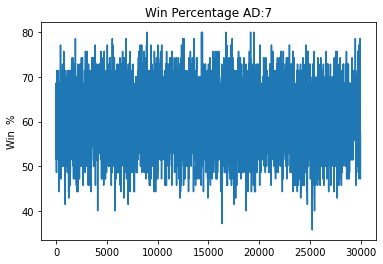

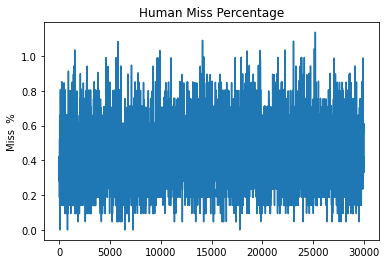

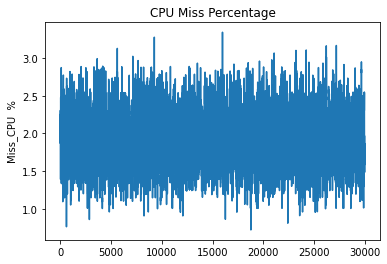

CPU times: user 12h 58min 3s, sys: 3min 8s, total: 13h 1min 11s
Wall time: 13h 1min 1s


In [18]:
%%time
TRAIN_MODEL = True
PLAYER_COLOR = 'B'

ADVANTAGE = 10
VIEW_BOARD = False

MODEL_PATH     = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_55-12.pth"
#MODEL_PATH     = "/content/drive/MyDrive/OTHELLO/SL_models/SLpn_conv4_bn_mini_30.pth"
#CPU_MODEL_PATH = "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_1_epoch_12.pth"

# 同時に複数種類のCPUと対戦させる
CPU_MODEL_PATHES = [
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_55-12.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_5.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_15.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_25.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_35.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_45.pth",
                    "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_55.pth",
                    #"random"
                    ]   
NUM_PROCESS = len(CPU_MODEL_PATHES)
#NUM_PROCESS = 8

GAMMA         = 0.99
LR = 1e-10 / NUM_PROCESS
CLIP = 5e-7
LR_STEP  = 3*30//ADVANTAGE #10episodeごとに更新
LR_GAMMA = 1
PENALTY = 0.3 # ミスしたときにrewardを減らす

MAX_ITER = 30000
TRETH    = 85 #直近10戦の平均勝率が80%を超えたら終了

MISS_count = [0]
MISS_count_CPU = [0]
DEVICE = 'cuda:0'

#ray.init(ignore_reinit_error=True, resources=["cuda:0"])
AAA = Environment(view_board=False)
WIN, MISSES, MISSES_CPU = AAA.train()

WIN = [int(w>0) for w in WIN]
print(f"Win Percentage {100*sum(WIN)/len(WIN)} %", )
print(f"Avarage Human MISS {np.mean(MISSES)} %" )
print(f"Avarage  CPU  MISS {np.mean(MISSES_CPU)} %" )

#ray.shutdown()
plot_graphs(WIN, MISSES, MISSES_CPU)

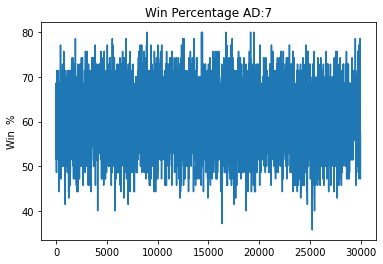

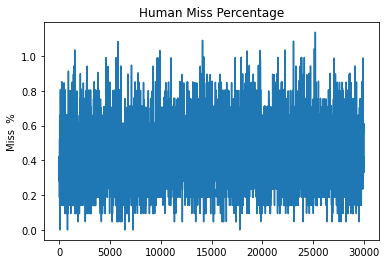

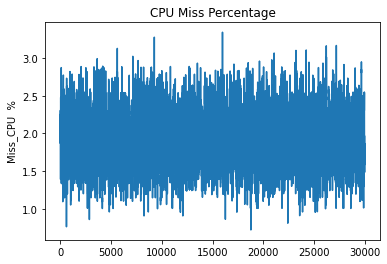

In [19]:
plot_graphs(WIN, MISSES, MISSES_CPU)


 Humans state Input !!!!!!!!!!!!!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


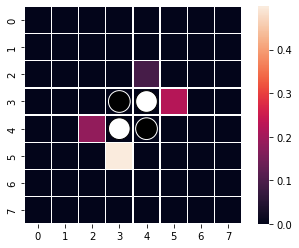

Humans Action : (tensor([3]), tensor([5])) tensor([43])

 CPUs state Input !!!!!!!!!!!!!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


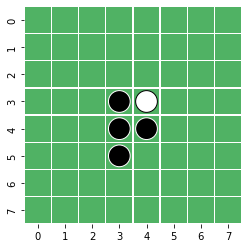

CPUs Action : (4, 5)

 Humans state Input !!!!!!!!!!!!!!!!!


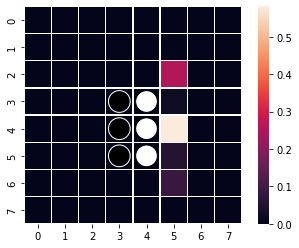

Humans Action : (tensor([5]), tensor([4])) tensor([37])

 CPUs state Input !!!!!!!!!!!!!!!!!


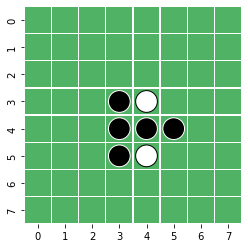

CPUs Action : (2, 5)

 Humans state Input !!!!!!!!!!!!!!!!!


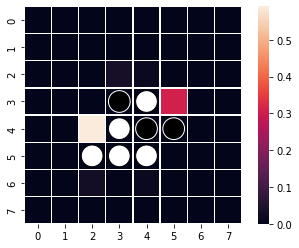

Humans Action : (tensor([2]), tensor([4])) tensor([34])

 CPUs state Input !!!!!!!!!!!!!!!!!


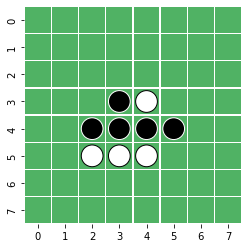

CPUs Action : (3, 2)

 Humans state Input !!!!!!!!!!!!!!!!!


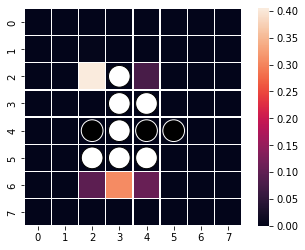

Humans Action : (tensor([2]), tensor([2])) tensor([18])

 CPUs state Input !!!!!!!!!!!!!!!!!


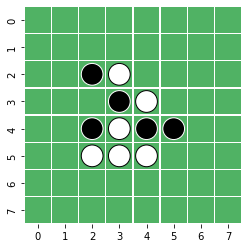

CPUs Action : (2, 3)

 Humans state Input !!!!!!!!!!!!!!!!!


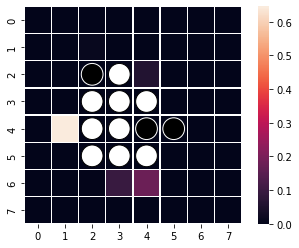

Humans Action : (tensor([1]), tensor([4])) tensor([33])

 CPUs state Input !!!!!!!!!!!!!!!!!


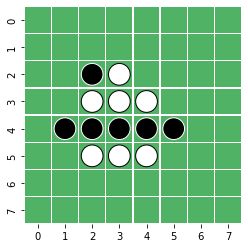

CPUs Action : (5, 5)

 Humans state Input !!!!!!!!!!!!!!!!!


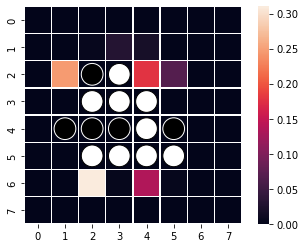

Humans Action : (tensor([4]), tensor([2])) tensor([20])

 CPUs state Input !!!!!!!!!!!!!!!!!


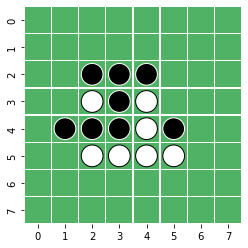

CPUs Action : (6, 3)

 Humans state Input !!!!!!!!!!!!!!!!!


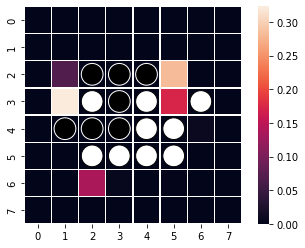

Humans Action : (tensor([2]), tensor([6])) tensor([50])

 CPUs state Input !!!!!!!!!!!!!!!!!


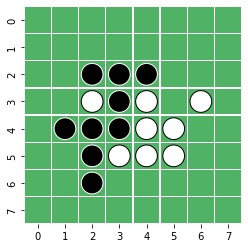

CPUs Action : (1, 3)

 Humans state Input !!!!!!!!!!!!!!!!!


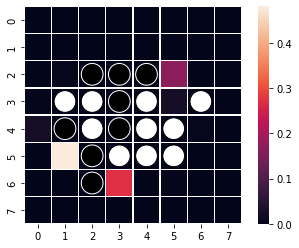

Humans Action : (tensor([1]), tensor([5])) tensor([41])

 CPUs state Input !!!!!!!!!!!!!!!!!


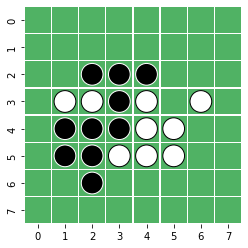

CPUs Action : (2, 7)

 Humans state Input !!!!!!!!!!!!!!!!!


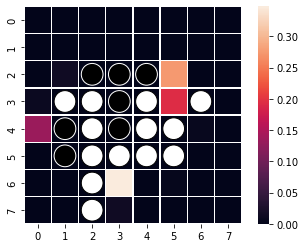

Humans Action : (tensor([0]), tensor([4])) tensor([32])

 CPUs state Input !!!!!!!!!!!!!!!!!


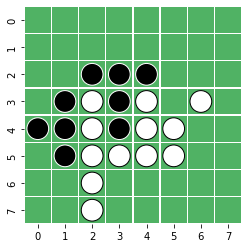

CPUs Action : (0, 2)

 Humans state Input !!!!!!!!!!!!!!!!!


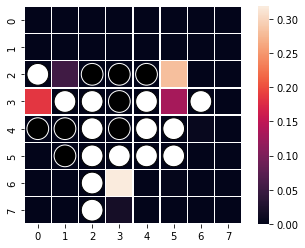

Humans Action : (tensor([5]), tensor([2])) tensor([21])

 CPUs state Input !!!!!!!!!!!!!!!!!


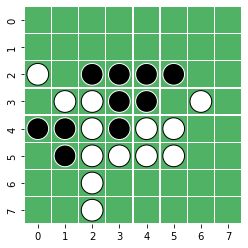

CPUs Action : (5, 3)

 Humans state Input !!!!!!!!!!!!!!!!!


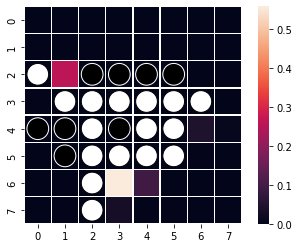

Humans Action : (tensor([4]), tensor([6])) tensor([52])

 CPUs state Input !!!!!!!!!!!!!!!!!


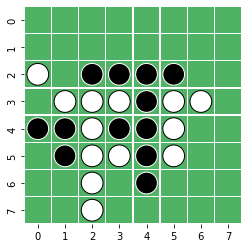

CPUs Action : (3, 6)

 Humans state Input !!!!!!!!!!!!!!!!!


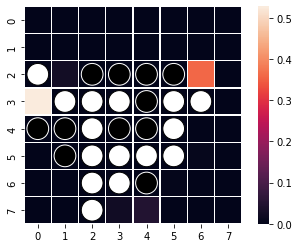

Humans Action : (tensor([0]), tensor([3])) tensor([24])

 CPUs state Input !!!!!!!!!!!!!!!!!


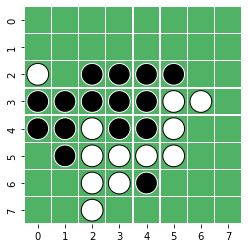

CPUs Action : (0, 5)

 Humans state Input !!!!!!!!!!!!!!!!!


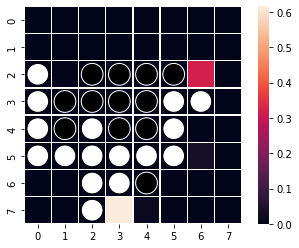

Humans Action : (tensor([3]), tensor([7])) tensor([59])

 CPUs state Input !!!!!!!!!!!!!!!!!


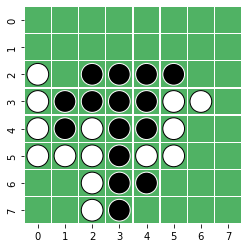

CPUs Action : (5, 7)

 Humans state Input !!!!!!!!!!!!!!!!!


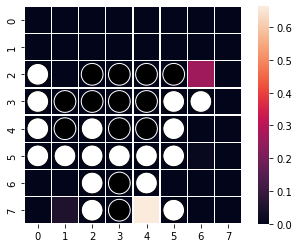

Humans Action : (tensor([1]), tensor([7])) tensor([57])

 CPUs state Input !!!!!!!!!!!!!!!!!


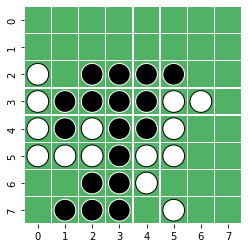

CPUs Action : (1, 2)

 Humans state Input !!!!!!!!!!!!!!!!!


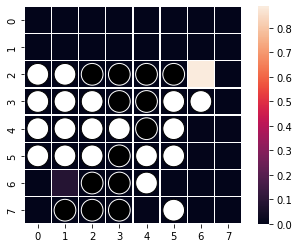

Humans Action : (tensor([6]), tensor([2])) tensor([22])

 CPUs state Input !!!!!!!!!!!!!!!!!


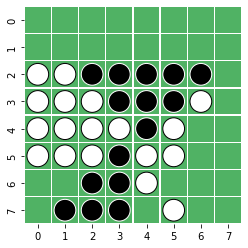

CPUs Action : (4, 7)

 Humans state Input !!!!!!!!!!!!!!!!!


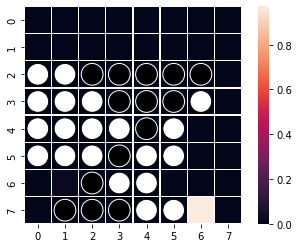

Humans Action : (tensor([6]), tensor([7])) tensor([62])

 CPUs state Input !!!!!!!!!!!!!!!!!


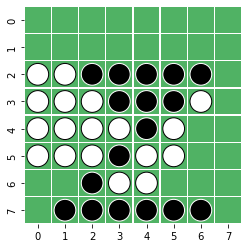

CPUs Action : (2, 1)

 Humans state Input !!!!!!!!!!!!!!!!!


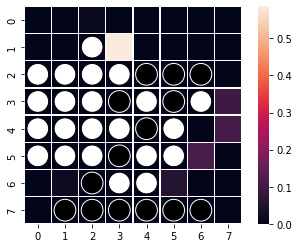

Humans Action : (tensor([7]), tensor([3])) tensor([31])

 CPUs state Input !!!!!!!!!!!!!!!!!


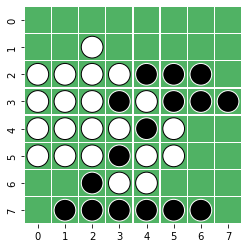

CPUs Action : (4, 1)

 Humans state Input !!!!!!!!!!!!!!!!!


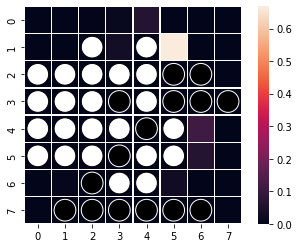

Humans Action : (tensor([5]), tensor([1])) tensor([13])

 CPUs state Input !!!!!!!!!!!!!!!!!


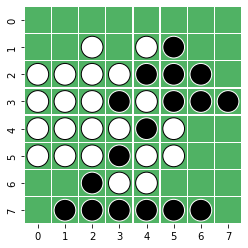

CPUs Action : (5, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


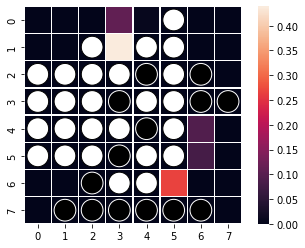

Humans Action : (tensor([5]), tensor([6])) tensor([53])

 CPUs state Input !!!!!!!!!!!!!!!!!


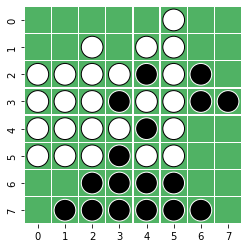

CPUs Action : (7, 2)

 Humans state Input !!!!!!!!!!!!!!!!!


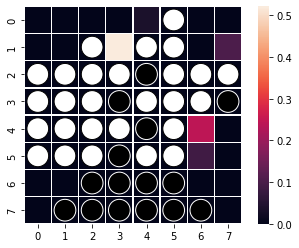

Humans Action : (tensor([4]), tensor([0])) tensor([4])

 CPUs state Input !!!!!!!!!!!!!!!!!


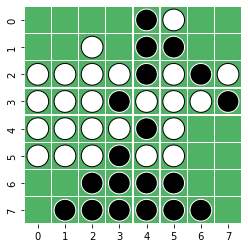

CPUs Action : (3, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


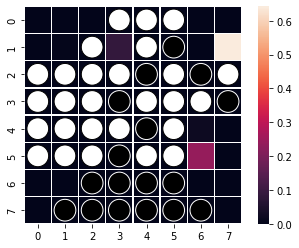

Humans Action : (tensor([7]), tensor([1])) tensor([15])

 CPUs state Input !!!!!!!!!!!!!!!!!


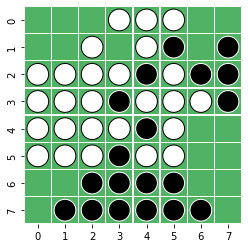

CPUs Action : (3, 1)

 Humans state Input !!!!!!!!!!!!!!!!!


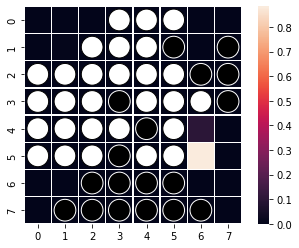

Humans Action : (tensor([6]), tensor([5])) tensor([46])

 CPUs state Input !!!!!!!!!!!!!!!!!


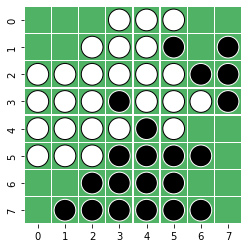

CPUs Action : (6, 6)

 Humans state Input !!!!!!!!!!!!!!!!!


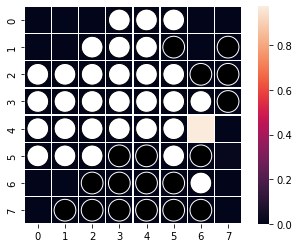

Humans Action : (tensor([6]), tensor([4])) tensor([38])

 CPUs state Input !!!!!!!!!!!!!!!!!


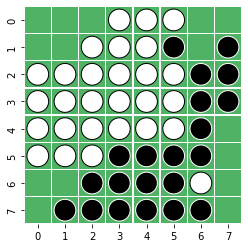

CPUs Action : (7, 5)

 Humans state Input !!!!!!!!!!!!!!!!!


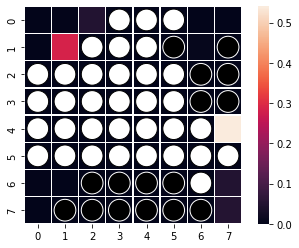

Humans Action : (tensor([7]), tensor([4])) tensor([39])

 CPUs state Input !!!!!!!!!!!!!!!!!


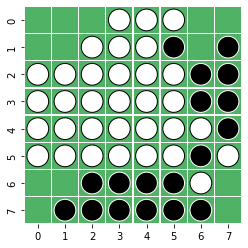

CPUs Action : (7, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


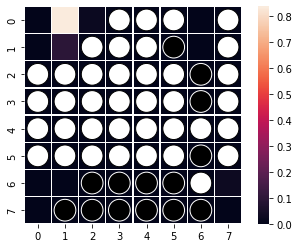

Humans Action : (tensor([1]), tensor([0])) tensor([1])

 CPUs state Input !!!!!!!!!!!!!!!!!


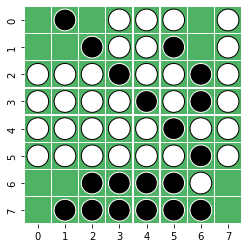

CPUs Action : (6, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


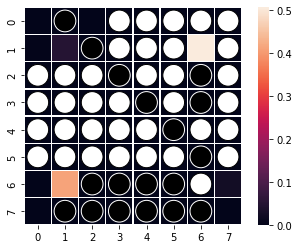

Humans Action : (tensor([6]), tensor([1])) tensor([14])

 CPUs state Input !!!!!!!!!!!!!!!!!


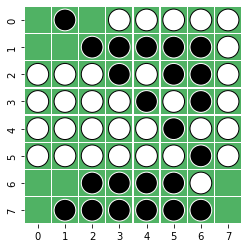

CPUs Action : (2, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


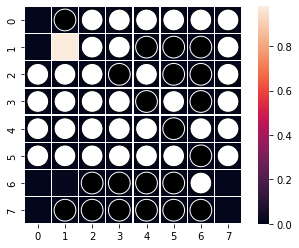

Humans Action : (tensor([1]), tensor([1])) tensor([9])

 CPUs state Input !!!!!!!!!!!!!!!!!


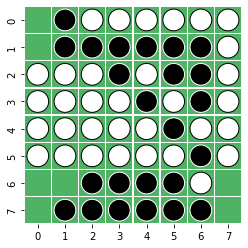

CPUs Action : (0, 0)

 Humans state Input !!!!!!!!!!!!!!!!!


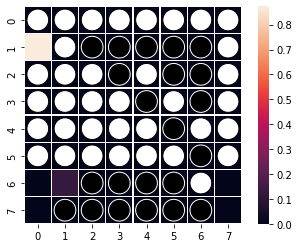

Humans Action : (tensor([0]), tensor([1])) tensor([8])

 CPUs state Input !!!!!!!!!!!!!!!!!


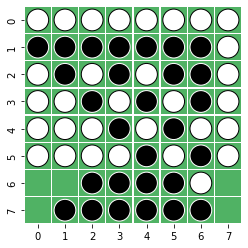

CPUs Action : (1, 6)

 Humans state Input !!!!!!!!!!!!!!!!!


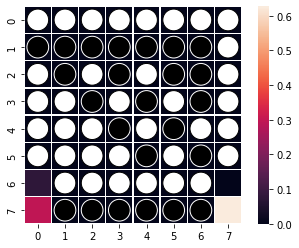

Humans Action : (tensor([0]), tensor([6])) tensor([48])

 CPUs state Input !!!!!!!!!!!!!!!!!


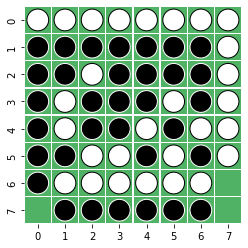

CPUs Action : (0, 7)

 Humans state Input !!!!!!!!!!!!!!!!!


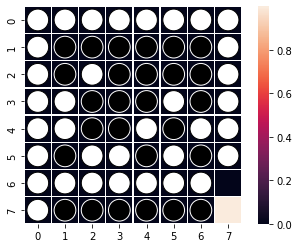

Humans Action : (tensor([7]), tensor([7])) tensor([63])

 CPUs state Input !!!!!!!!!!!!!!!!!


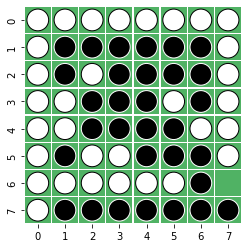

CPUs Action : (7, 6)

 最終盤面


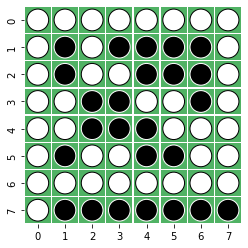

In [20]:
AAA.view_steps(view_board=True)

In [21]:
torch.save( AAA.Master.Network.state_dict(), "/content/drive/MyDrive/OTHELLO/SL_models/SL_Network_AugDH_epoch_55-30000.pth" )